## ARIMA, ARIMAX & SARMAX | BTC - EUR

![framwork](./framework.png)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import pmdarima as pm

from eda import *
from math import sqrt
from matplotlib import pyplot as plt
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf_ols
from statsmodels.tsa.arima.model import ARIMA

In [3]:
exchange = pd.read_csv("exchange_v2.csv")
exchange.head()

,date,Open,High,Low,Close,Adj Close,Volume,currency
0,2014-09-17,1.295908,1.298000,1.294090,1.295908,1.295908,0,EURUSD=X
1,2014-09-18,1.285017,1.292689,1.285017,1.285000,1.285000,0,EURUSD=X
2,2014-09-19,1.292140,1.292959,1.283203,1.292006,1.292006,0,EURUSD=X
3,2014-09-22,1.284076,1.286900,1.281953,1.284142,1.284142,0,EURUSD=X
4,2014-09-23,1.285298,1.289930,1.284589,1.285149,1.285149,0,EURUSD=X


###  Plotting the data

/home/satria/Documents/FinData/TimeSeriesAnalysis/eda.py:162: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method=method, inplace=True)


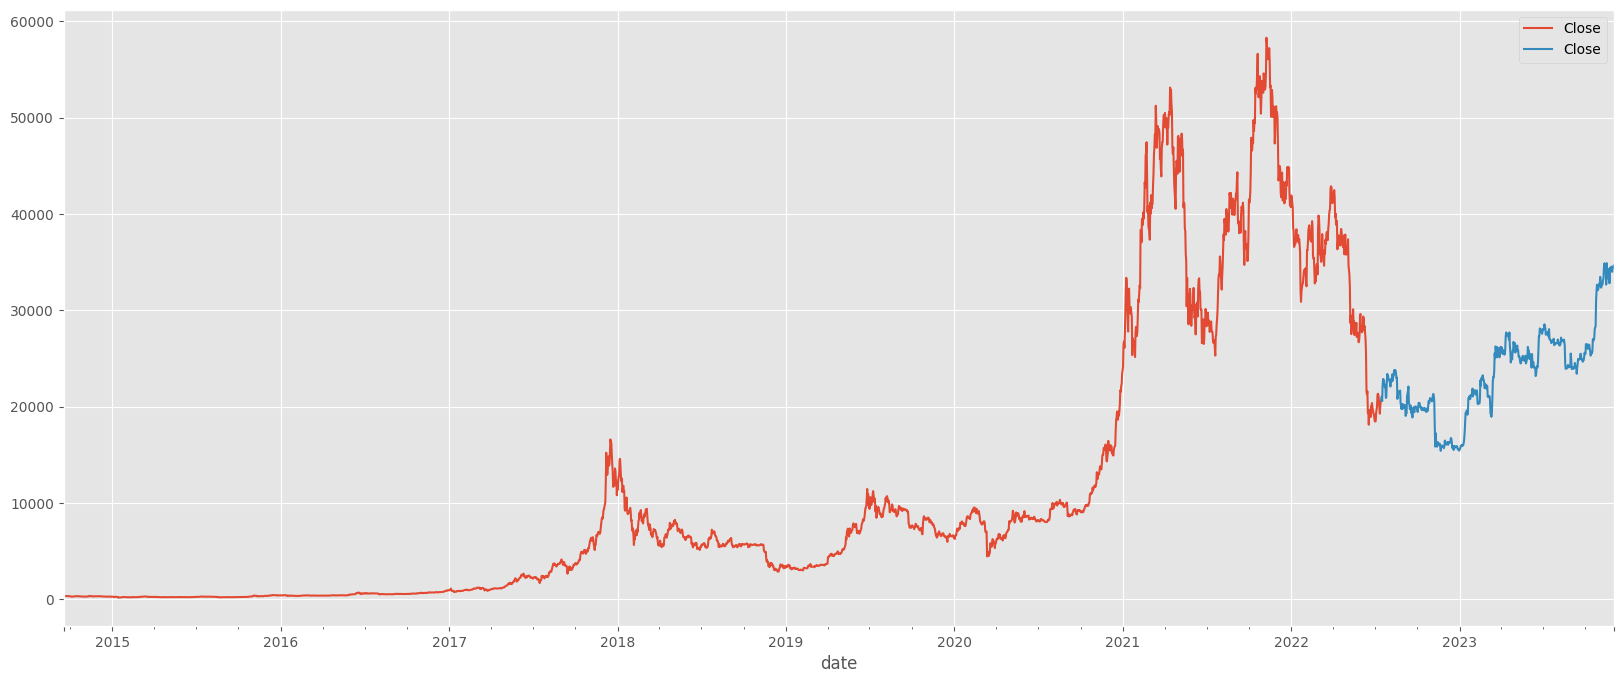

In [11]:
train_df_btc, test_df_btc = load_train_test_data(
    file_name='exchange_v2.csv', 
    currency='BTC-EUR',
    train_size=0.85
)
full_df_btc = pd.concat([train_df_btc, test_df_btc], ignore_index=True)
full_df_btc.to_csv('preprocessed_btceur.csv', index=False)

/home/satria/Documents/FinData/TimeSeriesAnalysis/eda.py:162: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method=method, inplace=True)


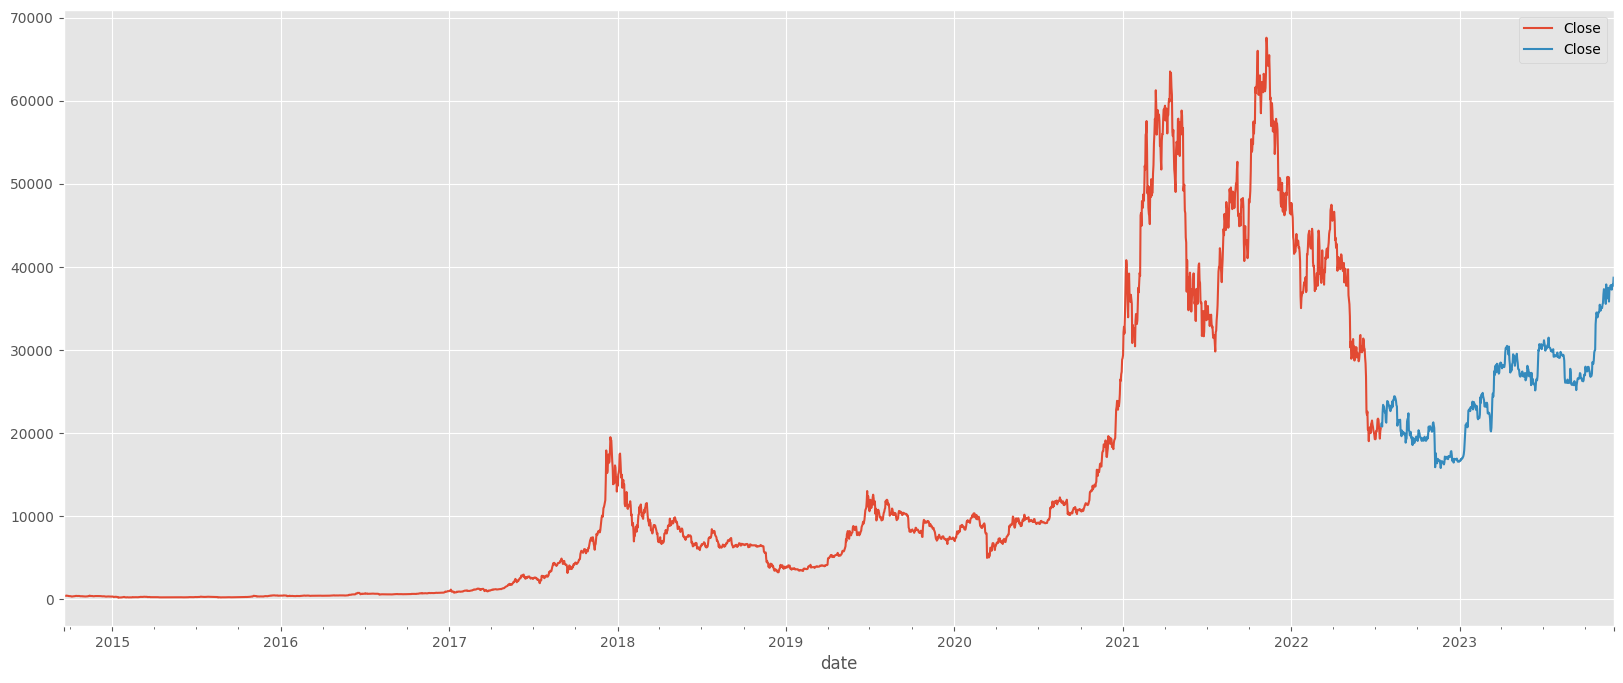

In [5]:
train_df_btcusd, test_df_btcusd = load_train_test_data(
    file_name='exchange_v2.csv', 
    currency='BTC-USD',
    train_size=0.85
)
full_df_btcusd = pd.concat([train_df_btcusd, test_df_btcusd], ignore_index=True)
full_df_btcusd.to_csv('preprocessed_btcusd.csv', index=False)

/home/satria/Documents/FinData/TimeSeriesAnalysis/eda.py:162: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method=method, inplace=True)


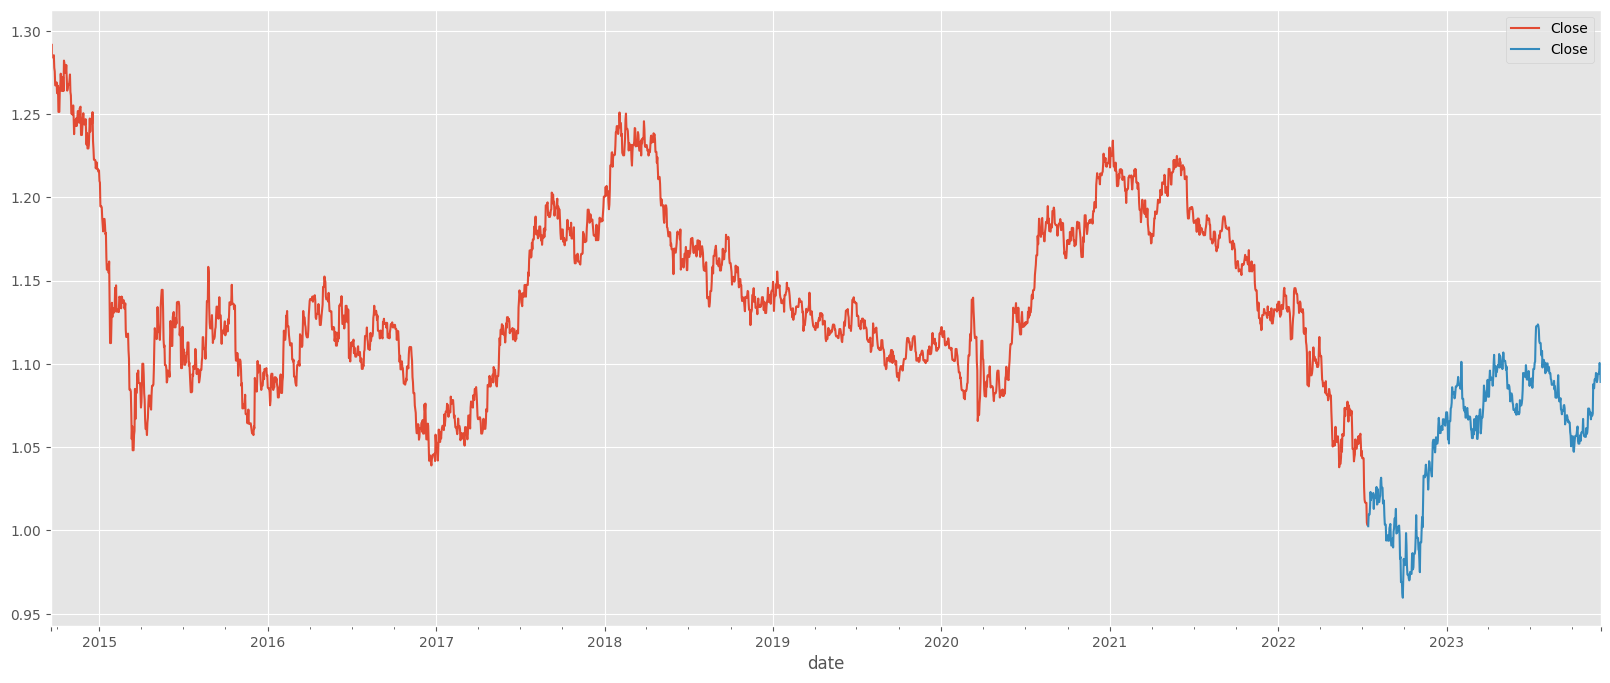

In [13]:
train_df_curr, test_df_curr = load_train_test_data(
    file_name='exchange_v2.csv', 
    currency='EURUSD=X',
    train_size=0.85
)
full_df_curr = pd.concat([train_df_curr, test_df_curr], ignore_index=True)
full_df_curr.to_csv('preprocessed_curr.csv', index=False)

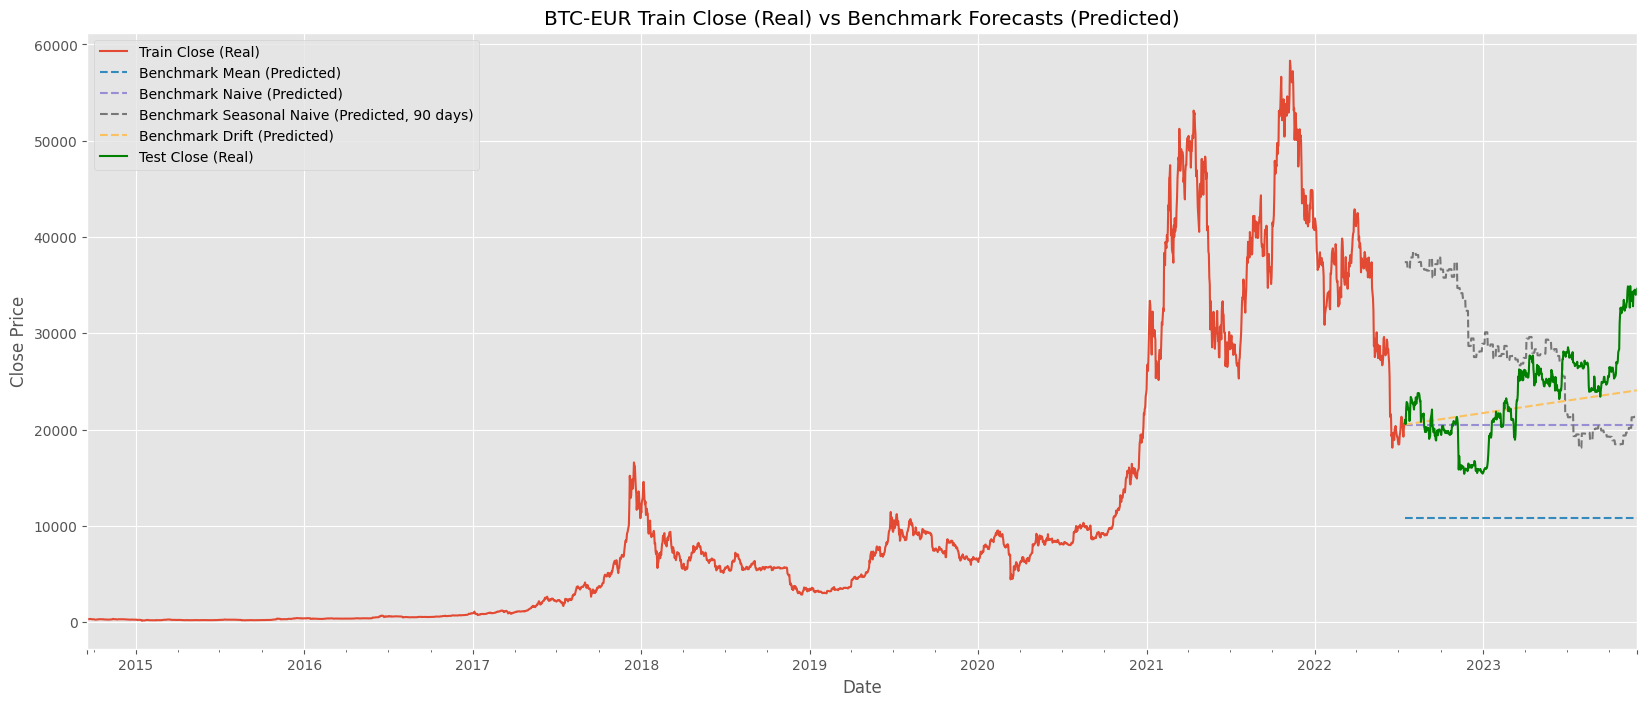

In [6]:
train_df_btc, test_df_btc = calc_benchmarks(train_df_btc, test_df_btc, seasonality=90)

### Transform the Data

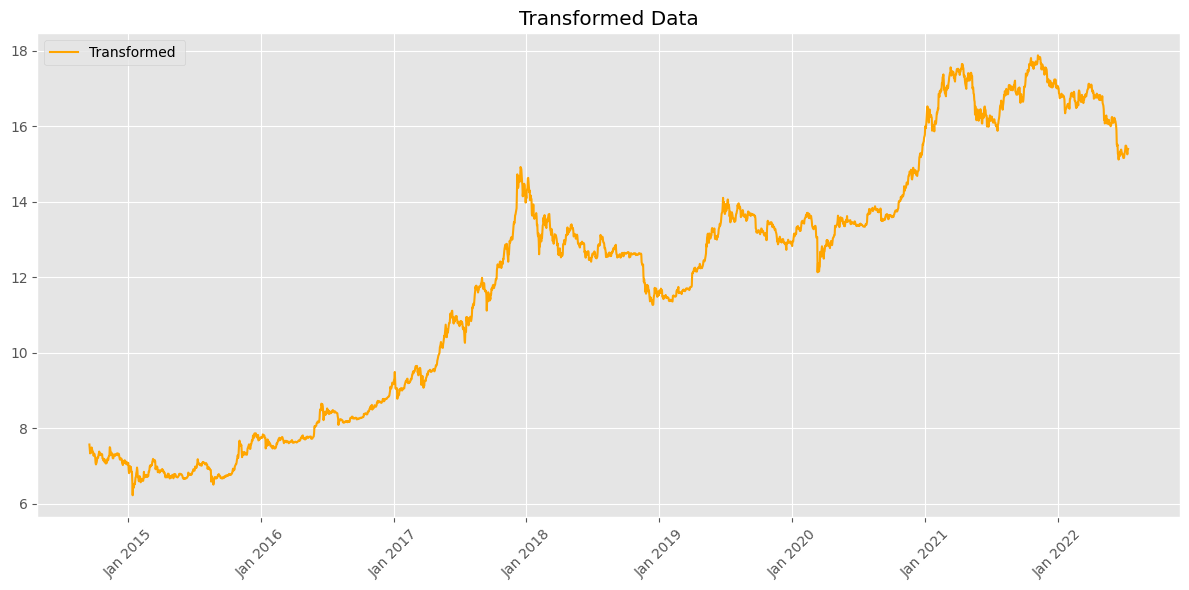

In [7]:
# # Apply box-cox transformation to the data
train_df_btc['transf'], lambda_optimal = stats.boxcox(train_df_btc['Close'])

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(train_df_btc['date']), train_df_btc['transf'], label='Transformed ', color='orange')
plt.title('Transformed Data')
plt.legend()
plt.grid(True)

# Set the date format for x-axis ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Specify the frequency of ticks for months
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


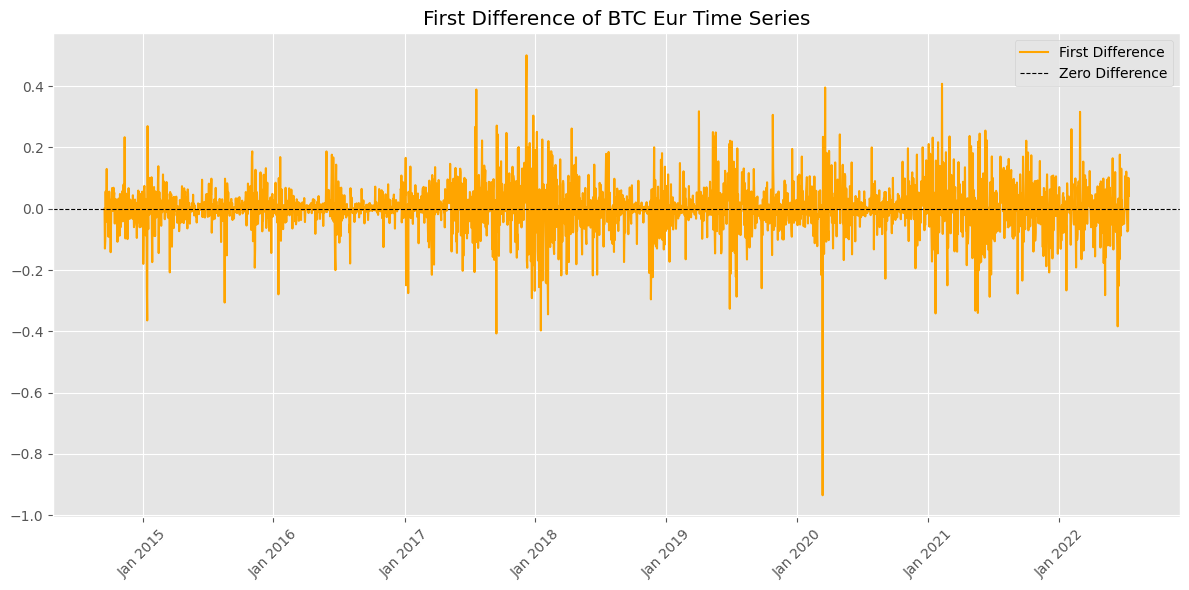

In [10]:
# Apply first differencing and check autocorrelation and plot

# Calculate the first difference
btceur_diff = train_df_btc.copy()
btceur_diff['diff'] = pd.Series.diff(train_df_btc['transf'])
btceur_diff.fillna(0, inplace=True)

# Plot only the first difference
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(btceur_diff['date']), btceur_diff['diff'], label='First Difference', color='orange')
plt.title('First Difference of BTC Eur Time Series')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, label='Zero Difference')
plt.legend()
plt.grid(True)

# Set the date format for x-axis ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Specify the frequency of ticks for months
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Autocorrelation and Partial Autocorrelation

In [11]:
acorr = sm.tsa.acf(btceur_diff['diff'], nlags = 2857)

# Lags in terms of 1 day, 1 month, 1 quarter, 1 year, 2 years, 5 years, and last lag
lags_of_interest = [0, 1, 30, 90, 365, 730, 1825, 2857]

# Print autocorrelations for specified lags
for lag in lags_of_interest:
    print(f'Lag {lag} ({lag} days): {acorr[lag]}')

Lag 0 (0 days): 1.0
Lag 1 (1 days): -0.02426479685277005
Lag 30 (30 days): 0.007950571484653014
Lag 90 (90 days): -0.016365166868627018
Lag 365 (365 days): -0.02909694227566002
Lag 730 (730 days): 0.0062881739519670705
Lag 1825 (1825 days): 0.006633875508549245
Lag 2857 (2857 days): -5.851999342040215e-06


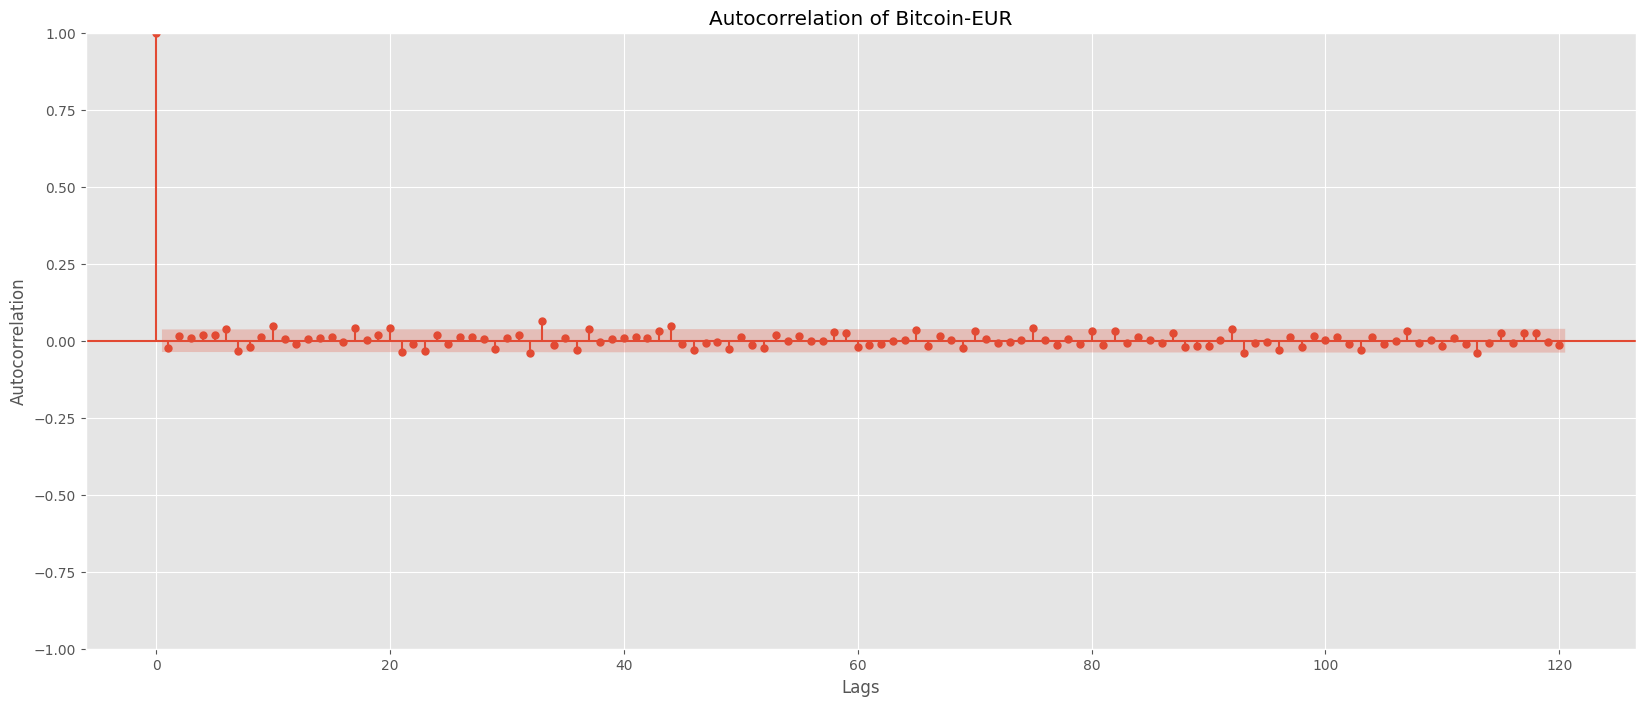

In [12]:
# Autocorrelation (3362 lags = +-10 years)
plot_acf(x = btceur_diff['diff'], lags=120)
plt.title('Autocorrelation of Bitcoin-EUR')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

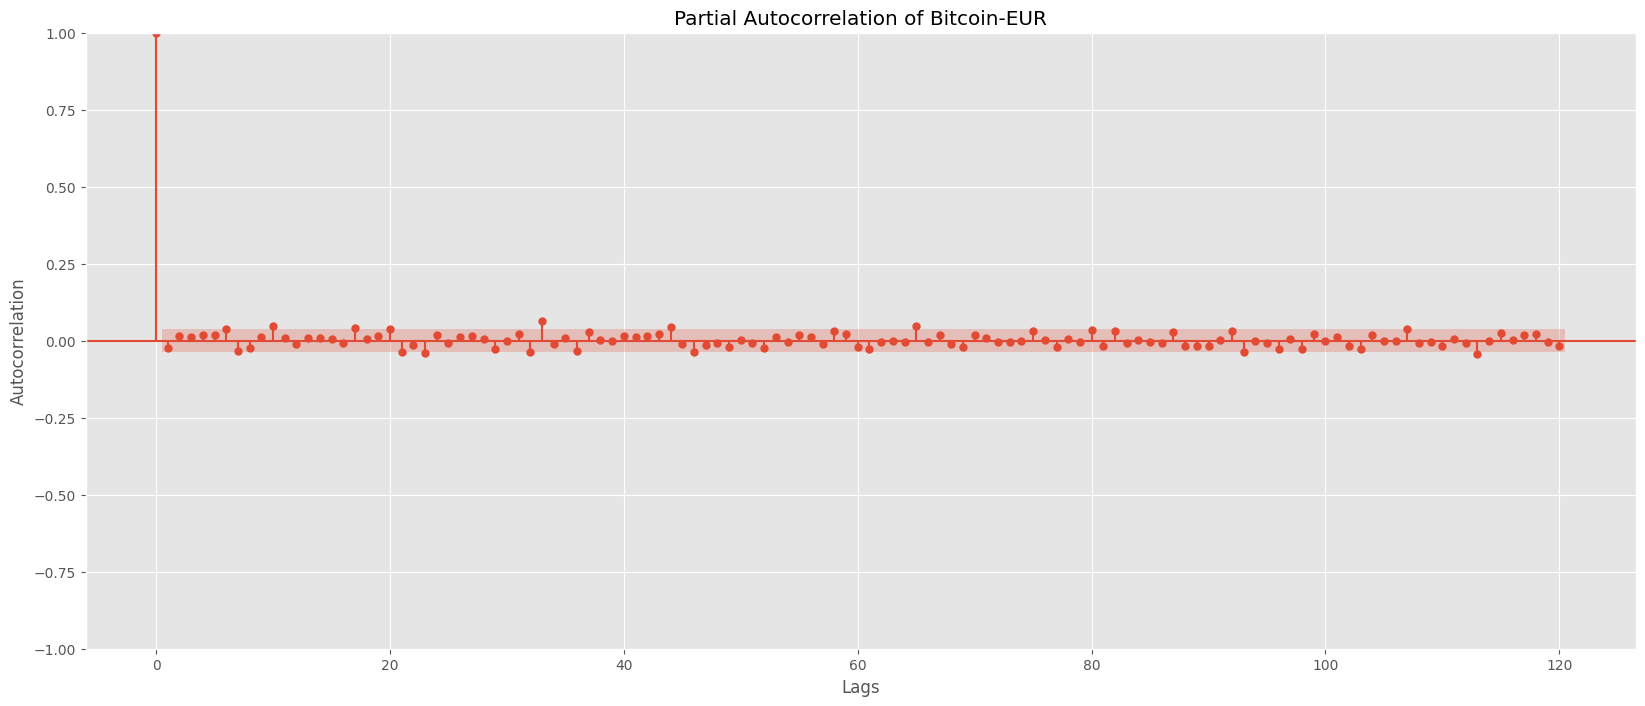

In [13]:
# Autocorrelation (3362 lags = +-10 years)
plot_pacf(x = btceur_diff['diff'], lags=120)
plt.title('Partial Autocorrelation of Bitcoin-EUR')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

### Fit ARIMA model

In [58]:
# Fit ARIMA model
def train_and_plot_arima(df, orders, exg=None):
    models = []
    # Plot the original dataset once
    plt.plot(df, label="Original Dataset", color='black', alpha=0.6, linewidth=2)
    
    # Loop through each combination and plot the fitted values
    for ar_order, i_order, ma_order in arima_combinations:

        if exg is not None:
            print("ARIMAX")
            model_fit = sm.tsa.SARIMAX(df, 
                                       exog=exg, 
                                       order=(ar_order, i_order, ma_order), 
                                       seasonal_order=(0, 0, 0, 0)).fit()
        else:    
            model_fit = ARIMA(df, order=(ar_order, i_order, ma_order)).fit()
            
        plt.plot(model_fit.fittedvalues, label=f'ARIMA({ar_order},{i_order},{ma_order})', alpha=0.9)
    
        # Save the model if you need it later
        models.append((model_fit, (ar_order, i_order, ma_order)))
    
    # Add legend and grid to the plot
    plt.legend()
    plt.grid(True)
    
    # Set the title and labels
    plt.title('Fitted Values of ARIMA Models')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    
    # Finally, show the plot
    plt.show()

    return models

def select_model(models):
    aic = models[0][0].aic
    model_fit = models[0][0]
    order = models[0][1]
    for model in models:
        if model[0].aic < aic:
            aic = model[0].aic
            model_fit = model[0]
            order = model[1]
            
    return model_fit

/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

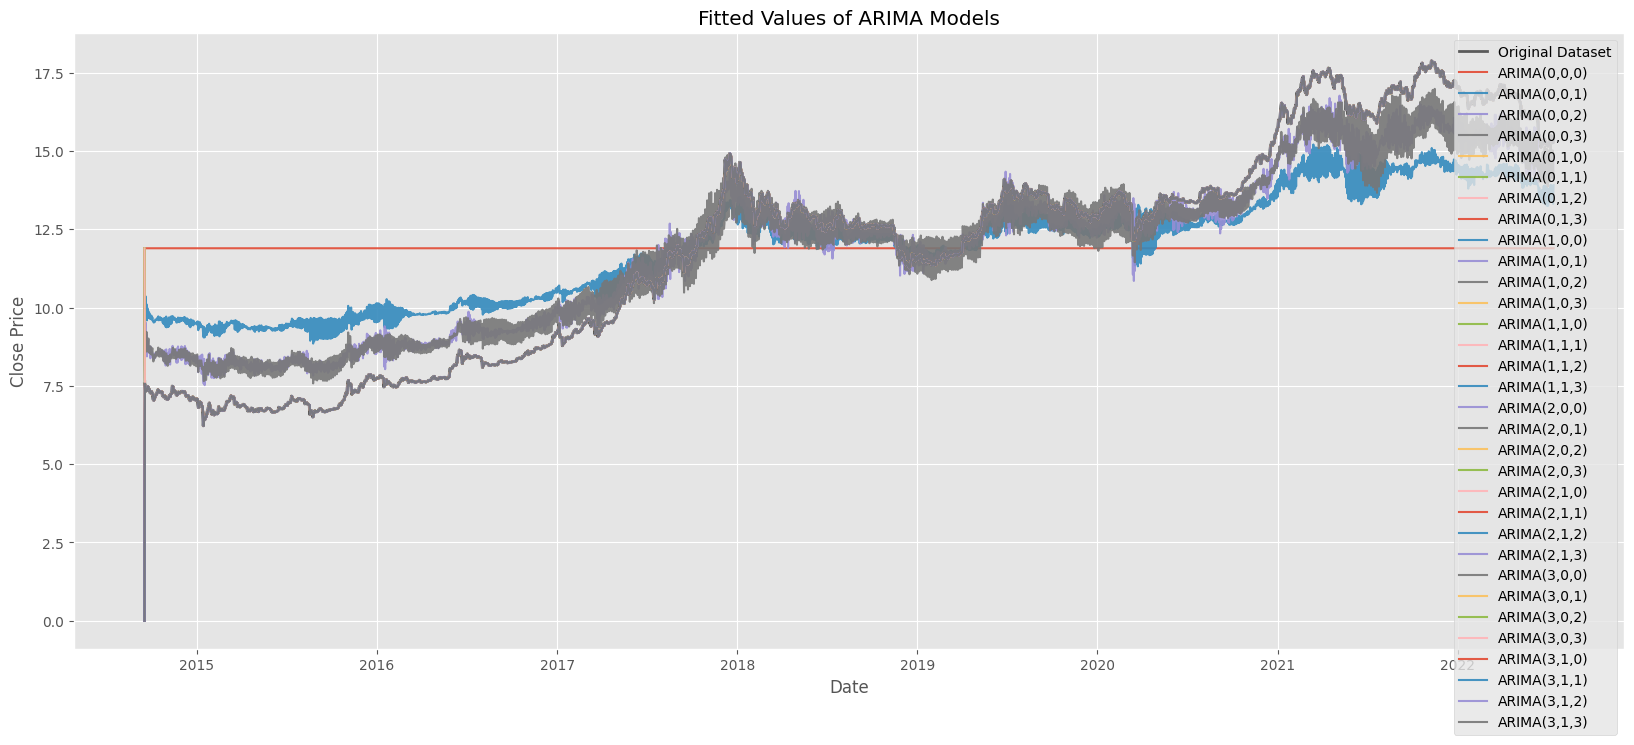

In [59]:
# Train ARIMA
arima_combinations = [(ar, i, ma) for ar in range(0,4) for i in [0,1] for ma in range(0,4)]  # Different combinations of AR and MA orders
models = train_and_plot_arima(train_df_btc['transf'], arima_combinations)

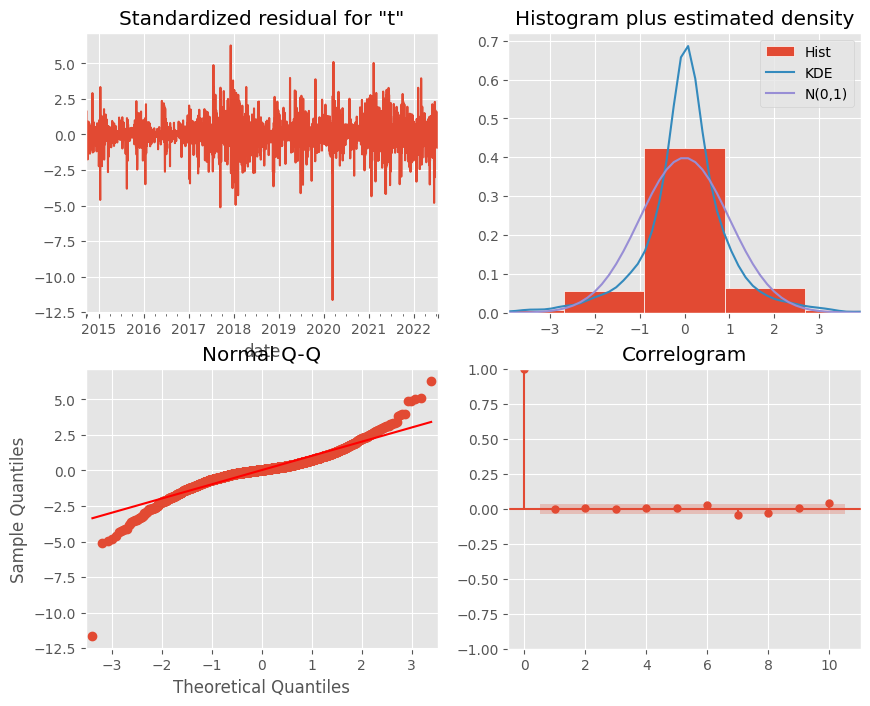

In [61]:
model_fit = select_model(models)
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [74]:
# Test against the the test dataset
# Make predictions on the test set

def forecast_and_plot(model_fit, df, test_df, transformed=False, lambda_optimal=None, exg=None):
    if exg is None:
        predictions = model_fit.forecast(steps=len(test_df['Close']))
    else:
        predictions = model_fit.forecast(steps=len(test_df['Close']), exog=exg)
    if transformed:
        predictions = inv_boxcox(predictions, lambda_optimal)
    
    # The index of 'predictions' should align with the index of 'test_df'
    predictions.index = test_df.index
    
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test_df["Close"], predictions))
    print('Test RMSE: %.3f' % rmse)
    
    # Plotting the results
    plt.figure(figsize=(12, 6))
    
    # Plot training data
    plt.plot(df["Close"], label='Training Data')
    
    # Plot predicted values
    plt.plot(predictions, color='blue', label='Predicted Test Data')
    
    # Plot actual test values
    plt.plot(test_df["Close"], color='green', label='Actual Test Data')
    
    plt.title('Train, Predicted Test, and Actual Test Data')
    plt.legend()
    
    plt.show()

Test RMSE: 5480.476


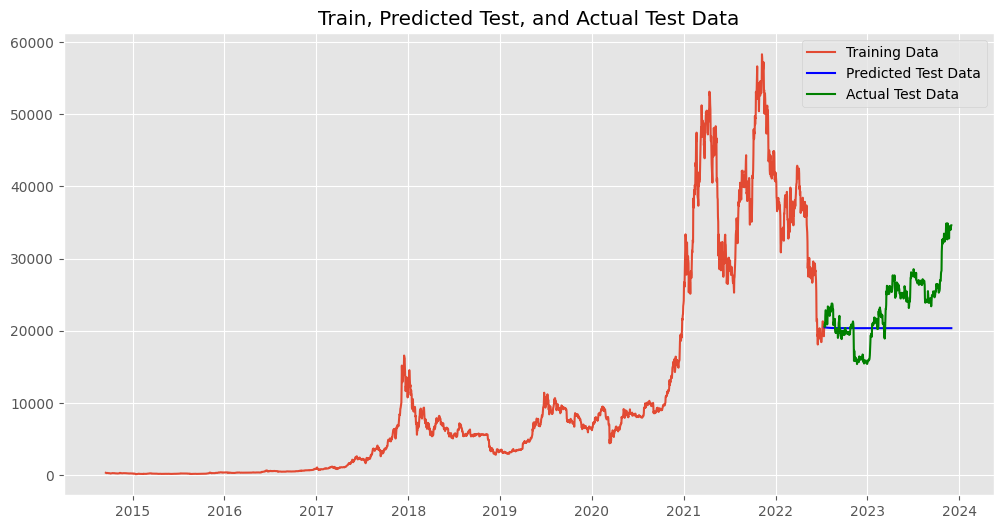

In [66]:
forecast_and_plot(model_fit, train_df_btc, test_df_btc, transformed=True, lambda_optimal=lambda_optimal)

### AUTO Arima and SARIMA

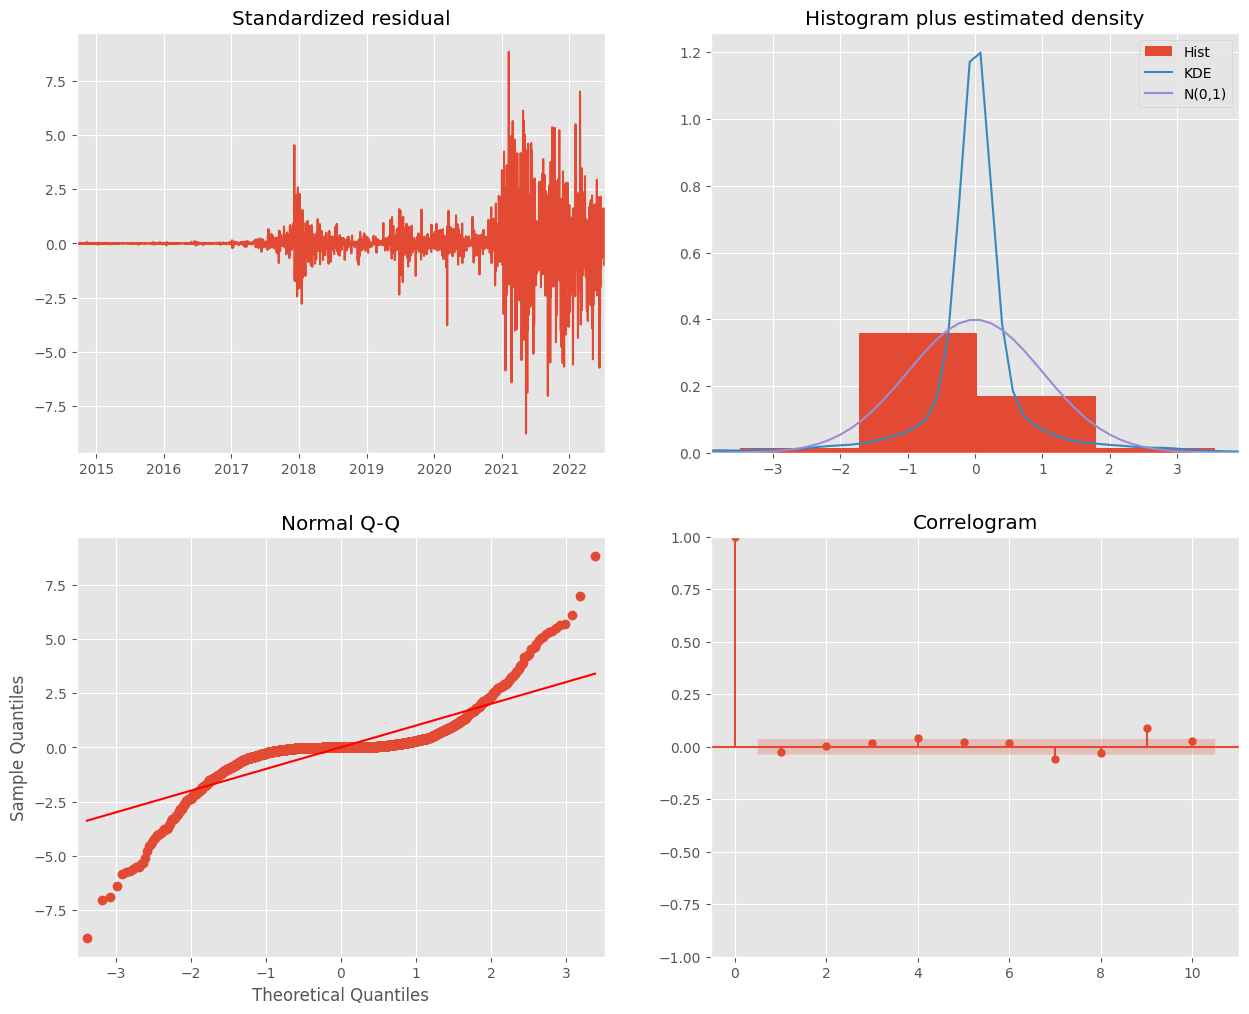

In [16]:
### Use auto arima
ARIMA_model = pm.auto_arima(train_df_btc["Close"], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

DatetimeIndex(['2022-07-15', '2022-07-16', '2022-07-17', '2022-07-18',
               '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
               '2022-07-23', '2022-07-24',
               ...
               '2023-11-22', '2023-11-23', '2023-11-24', '2023-11-25',
               '2023-11-26', '2023-11-27', '2023-11-28', '2023-11-29',
               '2023-11-30', '2023-12-01'],
              dtype='datetime64[ns]', length=505, freq='D')


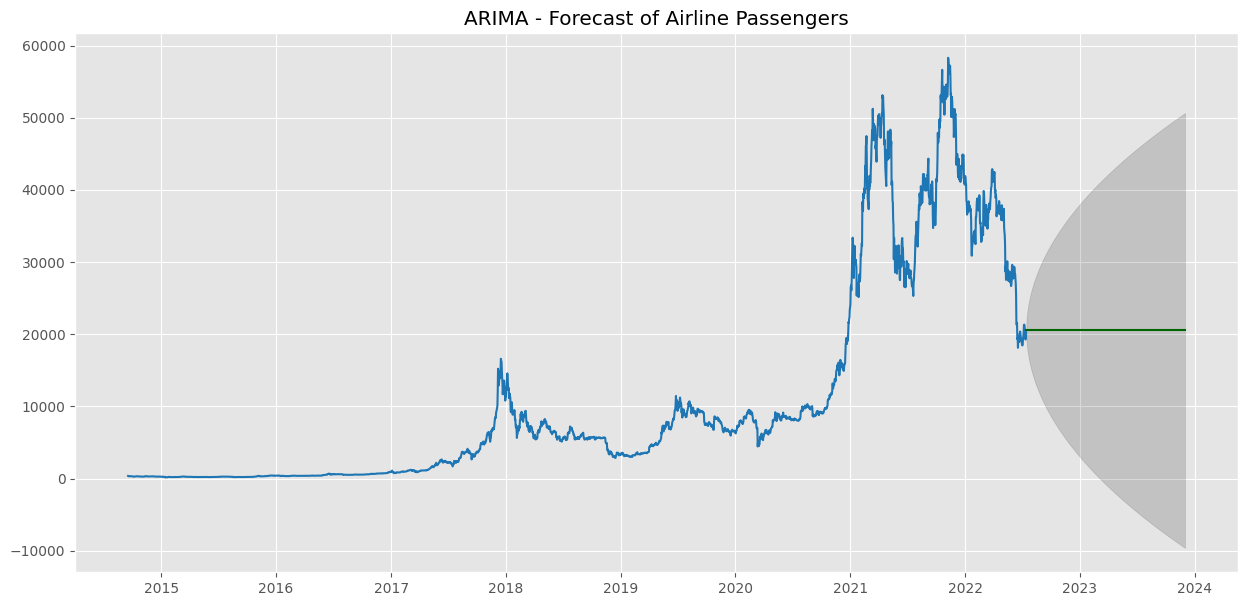

In [35]:
def forecast(ARIMA_model, df, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    print(index_of_fc)
    
    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df, color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA - Forecast of Airline Passengers")
    plt.show()

forecast(ARIMA_model, train_df_btc["Close"], periods=len(test_df_btc))

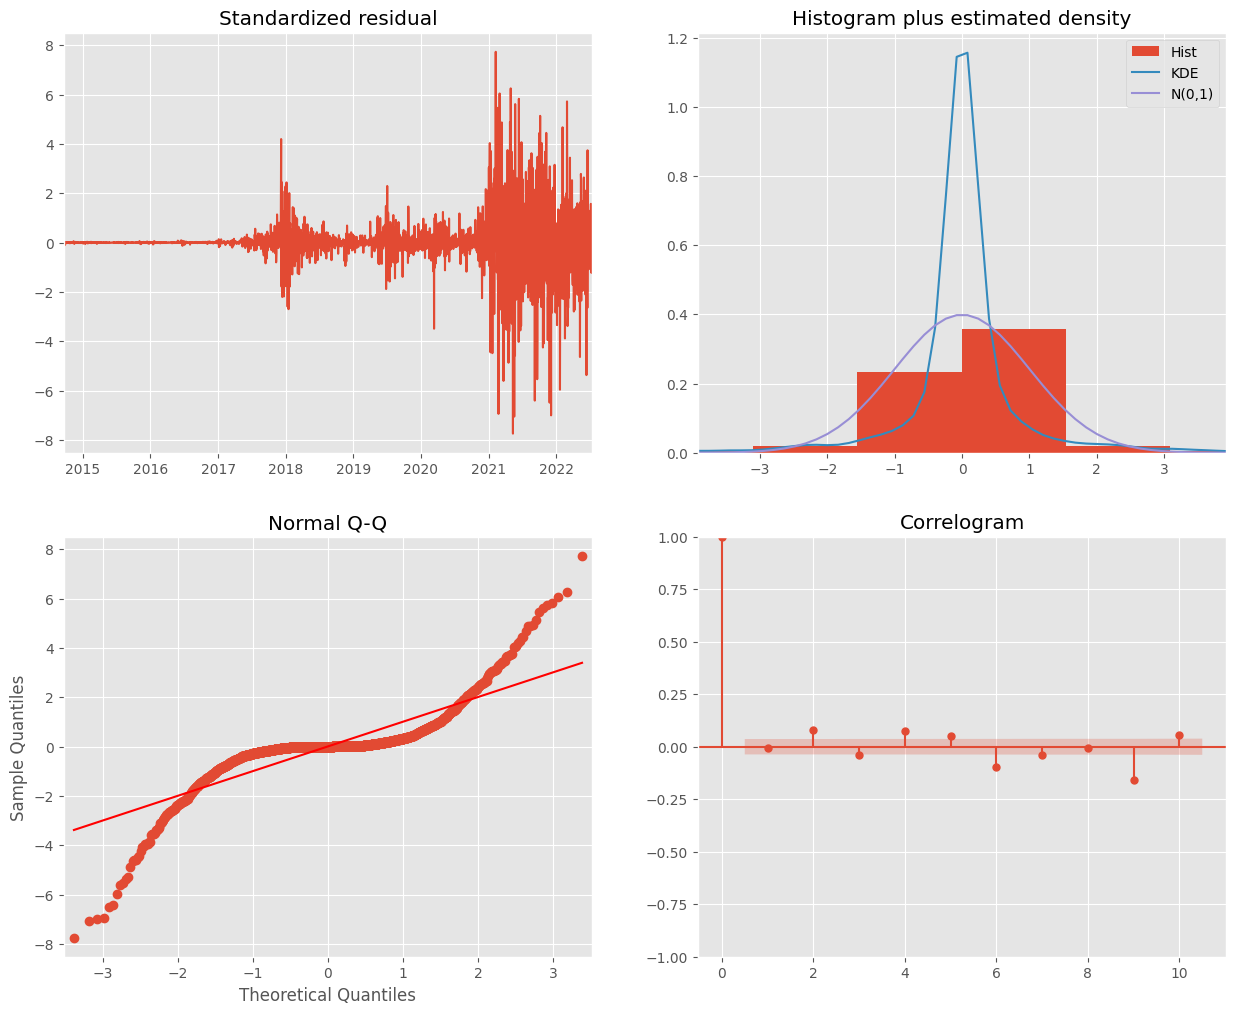

In [31]:
# Train SARIMA
SARIMA_model = pm.auto_arima(train_df_btc["Close"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=3,
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

DatetimeIndex(['2022-07-15', '2022-07-16', '2022-07-17', '2022-07-18',
               '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
               '2022-07-23', '2022-07-24',
               ...
               '2023-11-22', '2023-11-23', '2023-11-24', '2023-11-25',
               '2023-11-26', '2023-11-27', '2023-11-28', '2023-11-29',
               '2023-11-30', '2023-12-01'],
              dtype='datetime64[ns]', length=505, freq='D')


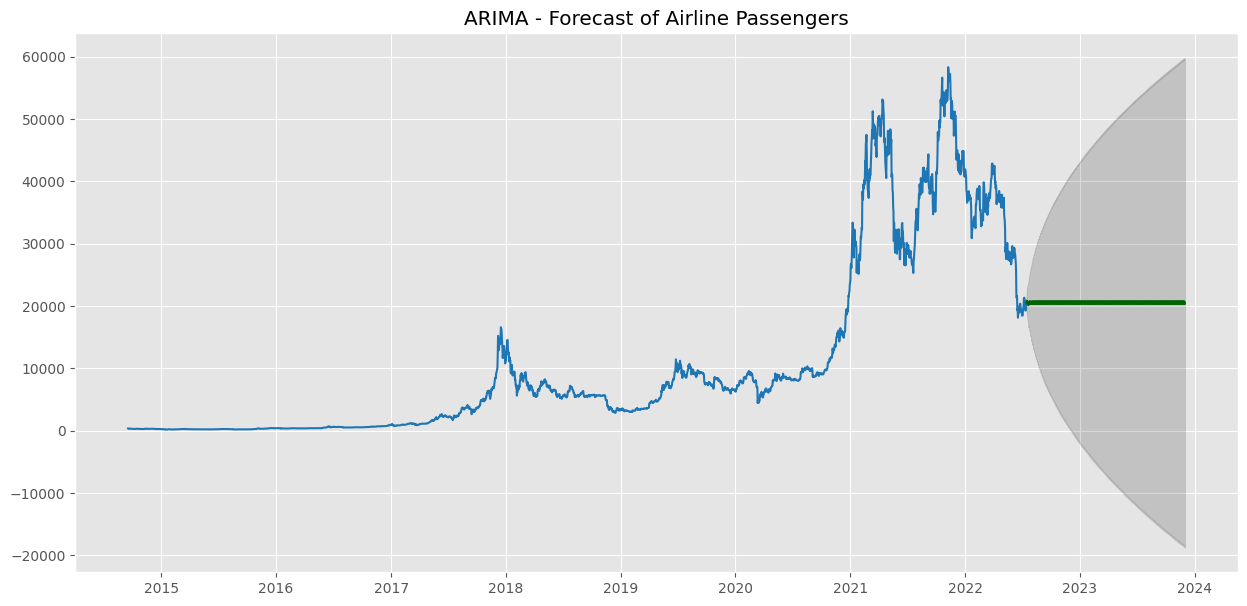

In [39]:
forecast(SARIMA_model, train_df_btc["Close"], periods=len(test_df_btc))

### Fit ARIMAX and SARIMAX

ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95982D+00    |proj g|=  4.93674D+08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   4.937D+08   5.960D+00
  F =   5.9598245775472467     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX


 This problem is unconstrained.
/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11131D+00    |proj g|=  3.64283D+11


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     21      1     0     0   3.643D+11   2.111D+00
  F =   2.1113102887289243     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04135D+00    |proj g|=  1.64356D+11


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     21      1     0     0   1.644D+11   2.041D+00
  F =   2.0413480048714039     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48072D+00    |proj g|=  1.41764D+12


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   1.418D+12   2.481D+00
  F =   2.4807166067189250     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37017D+00    |proj g|=  2.04529D+03


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   2.045D+03   2.370D+00
  F =   2.3701669689770970     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10784D+00    |proj g|=  6.14783D+06


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     21      1     0     0   6.148D+06  -1.108D+00
  F =  -1.1078395655888840     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10798D+00    |proj g|=  5.95957D+06


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     21      1     0     0   5.960D+06  -1.108D+00
  F =  -1.1079775134150733     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10803D+00    |proj g|=  5.80531D+06


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   5.805D+06  -1.108D+00
  F =  -1.1080282039795422     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10641D+00    |proj g|=  1.16278D+09


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     21      1     0     0   1.163D+09  -1.106D+00
  F =  -1.1064104466962239     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10666D+00    |proj g|=  1.28150D+09


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     21      1     0     0   1.281D+09  -1.107D+00
  F =  -1.1066587474321090     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10681D+00    |proj g|=  1.26971D+09


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   1.270D+09  -1.107D+00
  F =  -1.1068148304520984     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10688D+00    |proj g|=  1.24546D+09


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0   1.245D+09  -1.107D+00
  F =  -1.1068780657027328     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10785D+00    |proj g|=  6.13797D+06


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     21      1     0     0   6.138D+06  -1.108D+00
  F =  -1.1078494469374323     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10792D+00    |proj g|=  6.07967D+06


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     21      1     0     0   6.080D+06  -1.108D+00
  F =  -1.1079190148365166     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10861D+00    |proj g|=  3.79760D+06


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   3.798D+06  -1.109D+00
  F =  -1.1086057120347428     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10803D+00    |proj g|=  5.80131D+06


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0   5.801D+06  -1.108D+00
  F =  -1.1080334965641092     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10668D+00    |proj g|=  1.22431D+09


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     21      1     0     0   1.224D+09  -1.107D+00
  F =  -1.1066755654131963     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10681D+00    |proj g|=  1.25731D+09


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   1.257D+09  -1.107D+00
  F =  -1.1068109891205382     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10751D+00    |proj g|=  1.56148D+09


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem 


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0   1.561D+09  -1.108D+00
  F =  -1.1075077677429332     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.54712D+02    |proj g|=  1.85204D+15


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0   1.852D+15   6.547D+02
  F =   654.71247267375520     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10797D+00    |proj g|=  5.95836D+06


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     21      1     0     0   5.958D+06  -1.108D+00
  F =  -1.1079741997225423     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10832D+00    |proj g|=  5.49974D+06


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem 


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   5.500D+06  -1.108D+00
  F =  -1.1083229942620723     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10755D+00    |proj g|=  5.85875D+06


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0   5.859D+06  -1.108D+00
  F =  -1.1075527572328050     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10795D+00    |proj g|=  5.83718D+06


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0   5.837D+06  -1.108D+00
  F =  -1.1079533905078325     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10681D+00    |proj g|=  1.28084D+09


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   1.281D+09  -1.107D+00
  F =  -1.1068097797847478     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10676D+00    |proj g|=  1.26710D+09


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem 


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0   1.267D+09  -1.107D+00
  F =  -1.1067642668294271     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.54221D+02    |proj g|=  1.85065D+15


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem 


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0   1.851D+15   6.542D+02
  F =   654.22102758235735     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.54934D+02    |proj g|=  1.85266D+15


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      1     21      1     0     0   1.853D+15   6.549D+02
  F =   654.93373499428583     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10804D+00    |proj g|=  5.81865D+06


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   5.819D+06  -1.108D+00
  F =  -1.1080356488065159     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10804D+00    |proj g|=  5.81541D+06


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem 


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0   5.815D+06  -1.108D+00
  F =  -1.1080384628132514     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10755D+00    |proj g|=  5.86299D+06


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0   5.863D+06  -1.108D+00
  F =  -1.1075516758117481     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10795D+00    |proj g|=  5.82652D+06


/home/satria/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      1     21      1     0     0   5.827D+06  -1.108D+00
  F =  -1.1079546350558453     

ABNORMAL_TERMINATION_IN_LNSRCH                              


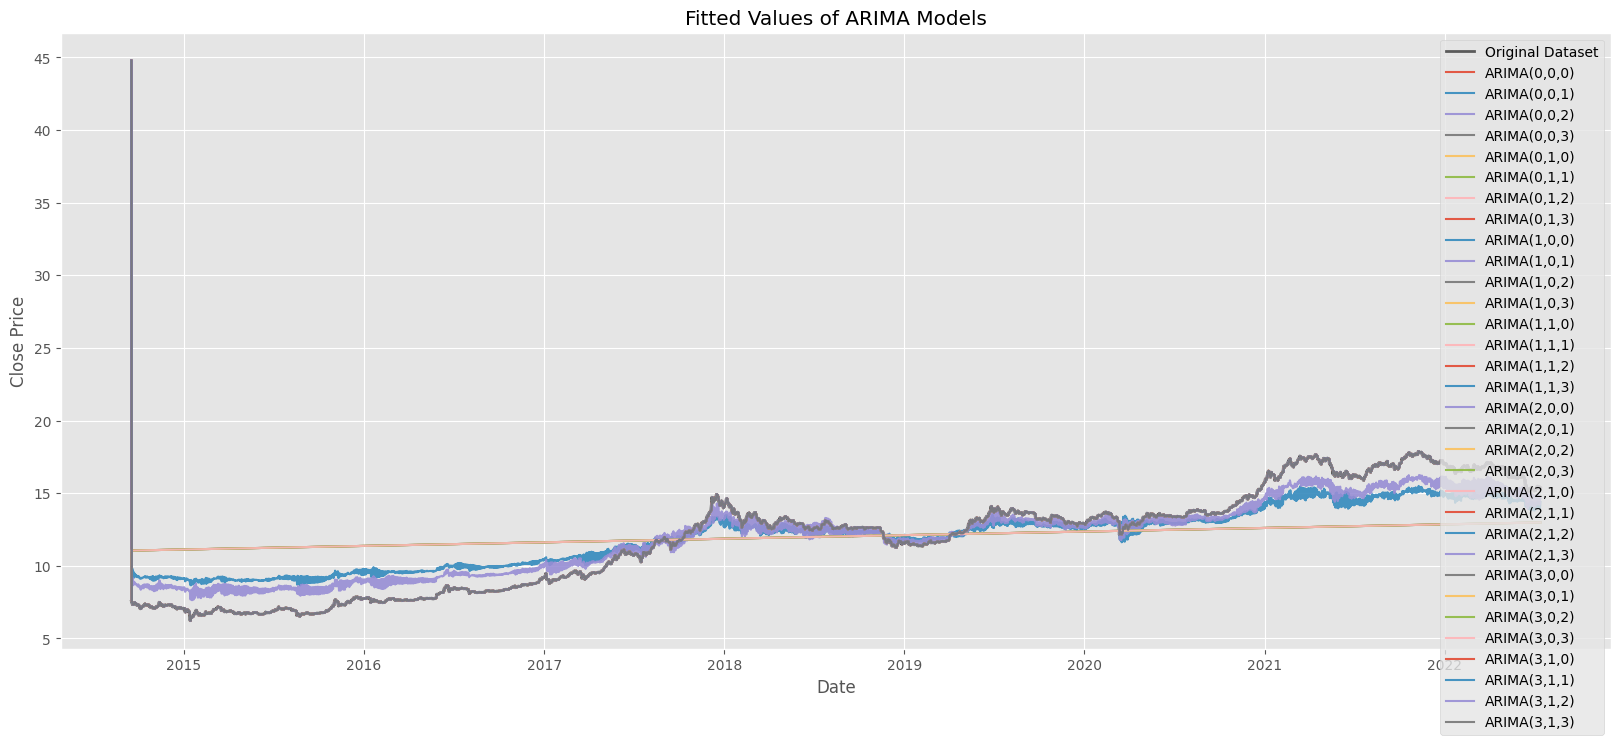

In [67]:
# Train ARIMAX
arima_combinations = [(ar, i, ma) for ar in range(0,4) for i in [0,1] for ma in range(0,4)]  # Different combinations of AR and MA orders
train_df_btc['epoch'] = (train_df_btc['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
models = train_and_plot_arima(train_df_btc['transf'], arima_combinations, exg=train_df_btc['epoch'])

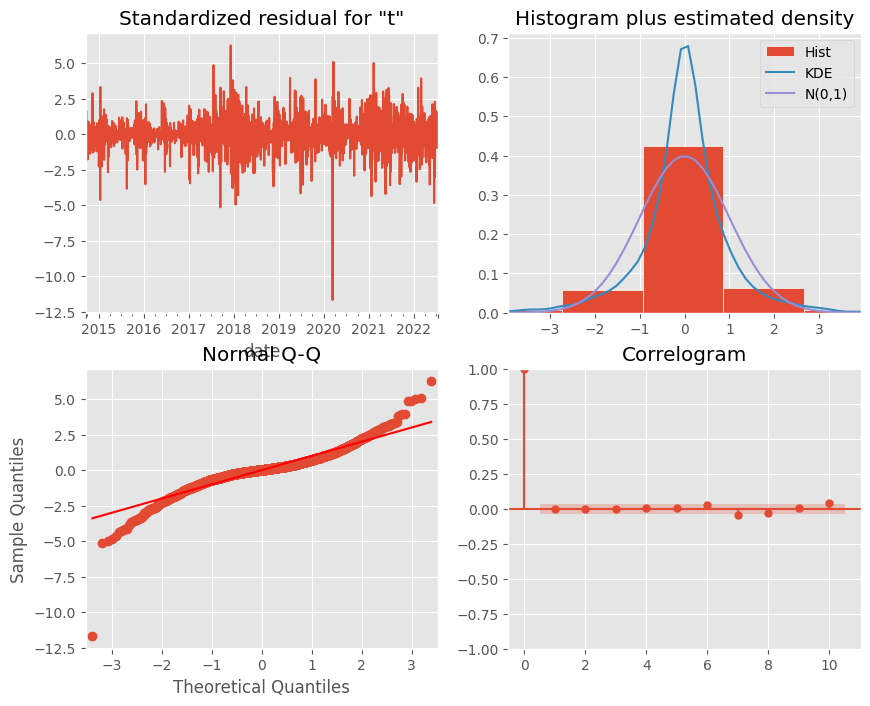

In [70]:
model_fit = select_model(models)
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

Test RMSE: 5479.600


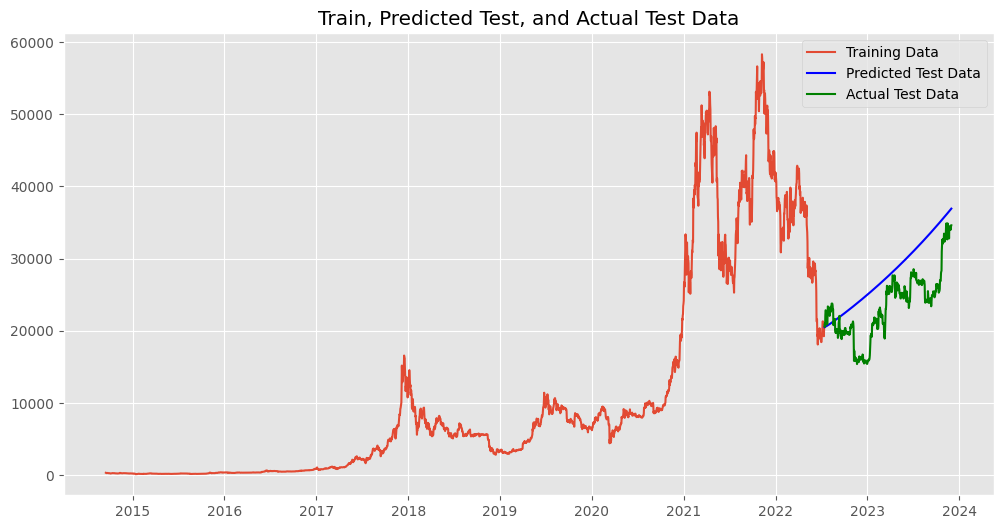

In [75]:
test_df_btc['epoch'] = (test_df_btc['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
forecast_and_plot(model_fit, train_df_btc, test_df_btc, transformed=True, lambda_optimal=lambda_optimal, exg=test_df_btc['epoch'])